In [21]:
import pandas as pd
import random
import numpy as np
from datetime import datetime, timedelta

In [22]:
# Define the product categories and products
product_categories = {
    'Dairy': ['Milk', 'Cottage Cheese', 'Cheese', 'Curd', 'Butter', 'Yogurt'],
    'Household': ['Detergent', 'Dishwasher', 'Cleaning Cloth', 'Mop', 'Broom', 'Toilet Paper'],
    'Personal Care': ['Shampoo', 'Conditioner', 'Soap', 'Toothpaste', 'Deodorant', 'Body Lotion'],
    'Snacks': ['Chips', 'Cookies', 'Biscuits', 'Candy', 'Popcorn', 'Granola Bars'],
    'Beverages': ['Juice', 'Soda', 'Tea', 'Coffee', 'Water', 'Energy Drink'],
    'Frozen Foods': ['Ice Cream', 'Frozen Vegetables', 'Frozen Pizza', 'Frozen Meals', 'Frozen Fish']
}

In [23]:
# Date range from 01-01-2022 to 26-09-2024
start_date = datetime(2022, 1, 1)
end_date = datetime(2024, 9, 26)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [24]:
# Define possible store locations and weekdays
store_locations = ['Rural', 'Urban', 'Suburban']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [31]:
# Randomize certain features
def generate_sales_data(date):
    product_category = random.choice(list(product_categories.keys()))
    product_name = random.choice(product_categories[product_category])
    sales_volume = np.random.randint(200, 1000)

    # Sales based on pattern (weekends, promotions, etc.)
    weekday = date.strftime('%A')
    if weekday in ['Saturday', 'Sunday']:
        sales_volume = int(sales_volume * random.uniform(1.1, 1.5))  # Higher sales on weekends

    # Promotions affect sales
    promotion = random.choice([0, 1])
    if promotion == 1:
        sales_volume = int(sales_volume * random.uniform(1.3, 2))  # Higher sales during promotions

    # Store locations and other details
    store_location = random.choice(store_locations)
    supplier_cost = round(np.random.uniform(2.5, 20), 2)
    replenishment_lead_time = random.randint(1, 10)
    stock_level = random.randint(50, 500)

    # Randomization based on date for seasonal demand
    if product_category == 'Frozen Foods' and date.month in [6, 7, 8]:
        sales_volume = int(sales_volume * random.uniform(1.2, 1.6))  # Increased demand in summer

    return [date.strftime('%d-%m-%Y'), product_category, product_name, sales_volume, round(np.random.uniform(5, 20), 2),
            promotion, store_location, weekday, supplier_cost, replenishment_lead_time, stock_level]

# Generate the data for each date
data = []
for date in date_range:
    num_entries = random.randint(2, 4)  # Each day can have 2-4 product categories
    for _ in range(num_entries):
        data.append(generate_sales_data(date))

# Multiply data to ensure the total number of rows exceeds 50,000
num_rows_needed = 50000
num_repeats = num_rows_needed // len(data) + 1
data_extended = data * num_repeats

# Trim the excess rows if necessary to ensure exactly 50,000 rows
data_final = data_extended[:num_rows_needed]

# Convert to DataFrame
df = pd.DataFrame(data_final, columns=[
    'Date', 'Product_Category', 'Product_Name', 'Sales_Volume', 'Price', 'Promotion', 'Store_Location',
    'Weekday', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level'
])

# Ensure the data is sorted by Date in ascending order
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')

In [32]:
# Reset index for cleaner data
df.reset_index(drop=True, inplace=True)

In [33]:
# Display the first few rows of the dataset
print(df.head())

        Date Product_Category    Product_Name  Sales_Volume  Price  Promotion  \
0 2022-01-01           Snacks           Candy          1496  18.44          1   
1 2022-01-01           Snacks        Biscuits           284   7.88          0   
2 2022-01-01            Dairy          Yogurt          1727  14.48          1   
3 2022-01-01           Snacks        Biscuits           284   7.88          0   
4 2022-01-01            Dairy  Cottage Cheese           513  17.21          1   

  Store_Location   Weekday  Supplier_Cost  Replenishment_Lead_Time  \
0          Rural  Saturday           8.12                        8   
1          Rural  Saturday          14.51                        6   
2          Rural  Saturday           6.14                        5   
3          Rural  Saturday          14.51                        6   
4       Suburban  Saturday          14.88                        4   

   Stock_Level  
0          123  
1          330  
2          222  
3          330  
4      

In [34]:
# Save the dataset as a CSV file (optional)
df.to_csv('sales_data_sorted_50000_rows.csv', index=False)

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [46]:
# Load your dataset (assuming it's in CSV format)
data = pd.read_csv("/content/sales_data_sorted_50000_rows.csv")

In [47]:
# Handle missing values if any
data.fillna(0, inplace=True)

In [48]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [49]:
# Filter out relevant columns for modeling
df = data[['Date', 'Sales_Volume', 'Price', 'Promotion', 'Store_Location', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level']]

In [50]:
# Handle one-hot encoding for 'Store_Location' column
df = pd.get_dummies(df, columns=['Store_Location'], drop_first=True)

In [51]:
# Check the column names to confirm what was generated after encoding
print(df.columns)

Index(['Date', 'Sales_Volume', 'Price', 'Promotion', 'Supplier_Cost',
       'Replenishment_Lead_Time', 'Stock_Level', 'Store_Location_Suburban',
       'Store_Location_Urban'],
      dtype='object')


In [52]:
# Normalize/scale the data using Min-Max scaler for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Sales_Volume', 'Price', 'Promotion', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level', 'Store_Location_Urban', 'Store_Location_Suburban']])

In [53]:
# Prepare sequences (using a window size of 30 for historical data)
def create_sequences(data, window_size=30):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i - window_size:i])  # Take previous `window_size` days as input features
        y.append(data[i, 0])  # The target is Sales_Volume (index 0 after scaling)
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data)

In [54]:
# Split into training (70%), validation (20%), and testing (10%) sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, shuffle=False)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33, shuffle=False)  # 0.33 * 0.3 = 0.1 for testing

In [55]:
# Build the LSTM model
model = Sequential()

In [56]:
# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# Add Dense layers for prediction
model.add(Dense(units=1))  # Output layer with 1 neuron for sales volume prediction

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,051 (125.20 KB)

 Trainable params: 32,051 (125.20 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [61]:
# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0138 - val_loss: 0.0108
Epoch 2/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - loss: 0.0117 - val_loss: 0.0098
Epoch 3/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 4/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 5/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 6/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 7/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 8/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 9/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 10/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 11/50
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 12

In [62]:
# Predict on the test data
y_pred = model.predict(x_test)

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [63]:
# Inverse scale the predictions and actual values back to original range
y_test_actual = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), x_test.shape[2] - 1)))))[:, 0]
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred, np.zeros((len(y_pred), x_test.shape[2] - 1)))))[:, 0]

In [64]:
# Calculate performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 151695.57171948702
Root Mean Squared Error (RMSE): 389.4811570788592


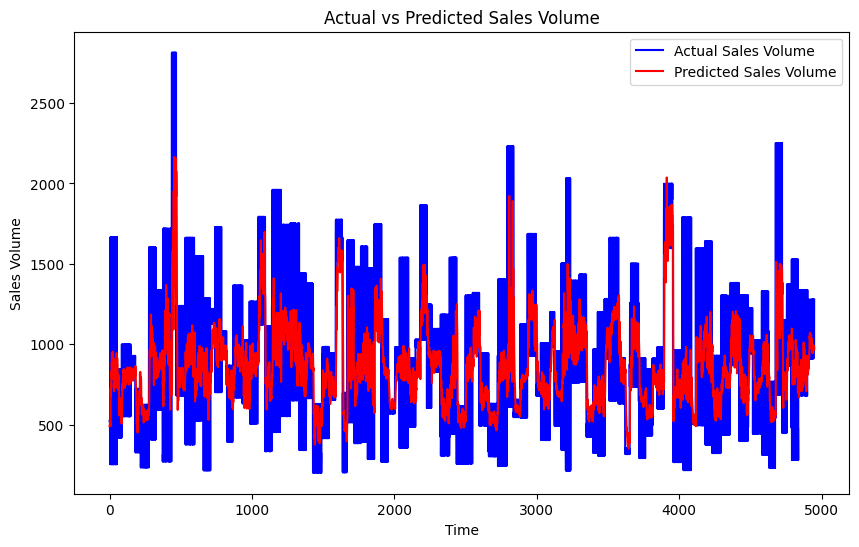

In [65]:
# Plot the actual vs predicted values for sales volume
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Actual Sales Volume')
plt.plot(y_pred_actual, color='red', label='Predicted Sales Volume')
plt.title('Actual vs Predicted Sales Volume')
plt.xlabel('Time')
plt.ylabel('Sales Volume')
plt.legend()
plt.show()